In [1]:
import torch
import matplotlib.pyplot as plt
import seaborn as sn
import pandas as pd
from torch import nn
from torchvision import datasets, transforms, models
import torchvision.models as models
from sklearn.metrics import confusion_matrix

from src.globals import MODEL_PATH, DEVICE


/home/hakim/.local/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def load_checkpoint(filepath):

    # checkpoint = torch.load(filepath,map_location='cpu') #unka
    checkpoint = torch.load(
        filepath, map_location=lambda storage, loc: storage)

    # model.load_state_dict(checkpoint['state_dict'])
    model = models.resnet34()
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, 5)
    model.load_state_dict(checkpoint['state_dict'])
    model.class_to_idx = checkpoint['class_to_idx']

    return model


In [3]:
test_transforms = transforms.Compose([transforms.Resize((244, 244)),
                                      transforms.ToTensor(),])
test_dir = './Dataset/Test'
test_dataset = datasets.ImageFolder(test_dir, transform=test_transforms)
testloader = torch.utils.data.DataLoader(
    test_dataset, batch_size=1024, shuffle=True)


In [4]:
def Cal_Accuracy(model):
    correct = 0
    total = 0
    model = model.to(DEVICE)
    predlist = torch.zeros(0, dtype=torch.long, device=DEVICE)
    lbllist = torch.zeros(0, dtype=torch.long, device=DEVICE)
    with torch.inference_mode():
        for data in testloader:
            images, labels = data
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            # Get probabilities
            outputs = model(images)
            # Turn probabilities into predictions
            _, predicted_outcome = torch.max(outputs.data, 1)
            # Total number of images
            total += labels.size(0)
            # Count number of cases in which predictions are correct
            correct += (predicted_outcome == labels).sum().item()
            # Append batch prediction results
            predlist = torch.cat([predlist, predicted_outcome.view(-1)])
            lbllist = torch.cat([lbllist, labels.view(-1)])

    conf_mat = confusion_matrix(lbllist.to(
        DEVICE).numpy(), predlist.to(DEVICE).numpy())
    Acc = round(100 * correct / total, 3)
    return Acc, conf_mat


In [5]:
model = load_checkpoint(MODEL_PATH)
accuracy, matrix = (Cal_Accuracy(model))
print("Accuracy:", accuracy, "%")
print("matrix:\n", matrix)


Accuracy: 54.0 %
matrix:
 [[28  1  1  0  0]
 [ 0 21  1  3  5]
 [ 2  4 11 12  1]
 [ 0  3  8 18  1]
 [ 1  8  1 17  3]]


In [6]:
class_accuracy = (100*matrix.diagonal()/matrix.sum(1)).round(2)
class_acc = dict(zip(test_dataset.classes, class_accuracy))
class_acc = sorted(class_acc.items(), key=lambda x: x[1])

for i in range(5):
    print(class_acc[i][0], "accuracy is:", class_acc[i][1], "%")


75% Rotten accuracy is: 10.0 %
25% Rotten accuracy is: 36.67 %
50% Rotten accuracy is: 60.0 %
100% Rotten accuracy is: 70.0 %
0% Rotten accuracy is: 93.33 %


<AxesSubplot: >

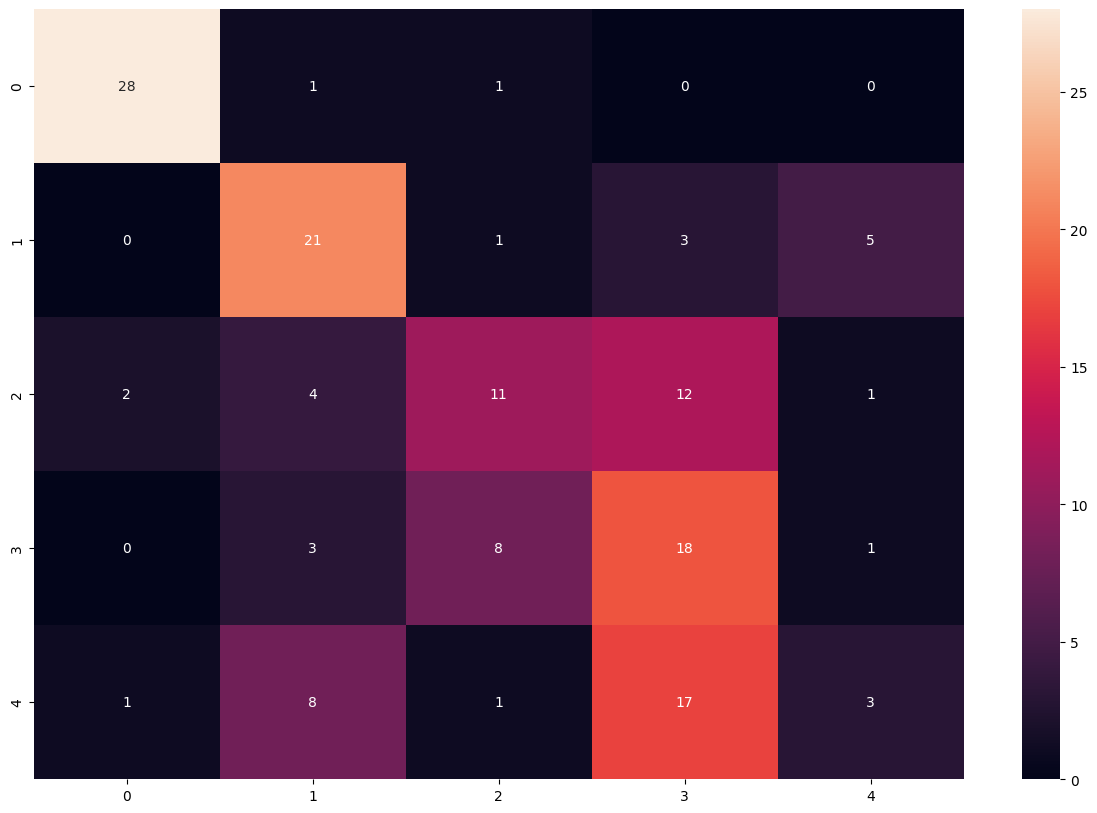

In [7]:

df_cm = pd.DataFrame(matrix, range(5), range(5))
plt.figure(figsize=(15, 10))
sn.heatmap(df_cm, annot=True)
